In [38]:
import re
import time
import psycopg2
import pandas as pd
from tqdm import tqdm
import geopy.distance
import matplotlib.pyplot as plt

### Connect to small database

In [5]:
conn = psycopg2.connect(
    host="localhost",
    database="krakow",
    user="postgres",
    password="postgres")

In [6]:
conn.autocommit = True
cursor = conn.cursor() 

### Get result helper function

In [7]:
def get_results(cursor):  
    result = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]

    print(columns)

    for row in result:
        print(row)

### Check data size and number of records

In [8]:
size_query = "SELECT pg_size_pretty( pg_database_size('krakow') ); "

records_nb_query = "SELECT COUNT(*) FROM edge_table;"

In [9]:
cursor.execute(records_nb_query)
get_results(cursor)

['count']
(721628,)


In [10]:
cursor.execute(size_query)
get_results(cursor)

['pg_size_pretty']
('124 MB',)


### Plotting function

In [39]:
def plot_query_times(query_times, save=False, filepath=None):
    query_nb = [i for i in range(1, len(query_times) + 1)]
    plt.plot(query_nb, query_times, marker=".", color="teal")
    plt.xlabel("Query number")
    plt.ylabel("Query execution time [ms]")
    
    if save:
        plt.show()
        plt.savefig(filepath, bbox_inches="tight", dpi=200)
        plt.close()
        
    else:
        plt.show()

### Nodes selection

In [12]:
nodes = pd.read_csv("./data/krakow/nodes_neo4j.csv")

In [14]:
# two random osmid
distance_small = 0
osmid_1_small = 0
osmid_2_small = 0

while distance_small < 25:
    start_and_finish = nodes.sample(2)

    osmid_1_small = int(start_and_finish.iloc[0]["osmid"])
    osmid_2_small = int(start_and_finish.iloc[1]["osmid"])

    coords_1 = start_and_finish.iloc[0]["y"], start_and_finish.iloc[0]["x"]
    coords_2 = start_and_finish.iloc[1]["y"], start_and_finish.iloc[1]["x"]
    
    distance_small = geopy.distance.distance(coords_1, coords_2).km

print(f"osmid_1_small: {osmid_1_small}, osmid_2_small: {osmid_2_small}, distance: {distance_small} km")

osmid_1_small: 11245963370, osmid_2_small: 3460386739, distance: 25.976786861057324 km


### Paths queries and parsing query time

In [20]:
dijkstra_benchmark = f"""
    EXPLAIN ANALYZE 
    SELECT * FROM pgr_dijkstra(
    'SELECT id, source, target, length as cost, length as reverse_cost FROM edge_table',
    {osmid_1_small}, {osmid_2_small},
    directed => false);
"""
astar_benchmark = f"""
    EXPLAIN ANALYZE
    SELECT * FROM pgr_aStar(
    'SELECT id, source, target, length as cost, length as reverse_cost, x1, y1, x2, y2 FROM edge_table',
    {osmid_1_small}, {osmid_2_small},
    directed => false);
"""

In [41]:
def parse_query_time(cursor):
    result = cursor.fetchall()
    time = int(re.findall("\d+", result[-1][0])[0])
    return time

### How many queries

In [45]:
query_number = 30

### Djikstra small distance, small database

In [46]:
cursor.execute(dijkstra_benchmark)
query_time = parse_query_time(cursor)
print(f"query time: {query_time} ms")

query time: 1250 ms


Query: 100%|██████████| 30/30 [00:41<00:00,  1.38s/it]

queries times: [1288, 1237, 1272, 1281, 1278, 1250, 1223, 1298, 1217, 1287, 1341, 1300, 1397, 1283, 1259, 1208, 1232, 1246, 1289, 1288, 1268, 1262, 1253, 1354, 1343, 1313, 1278, 1275, 1271, 1294]


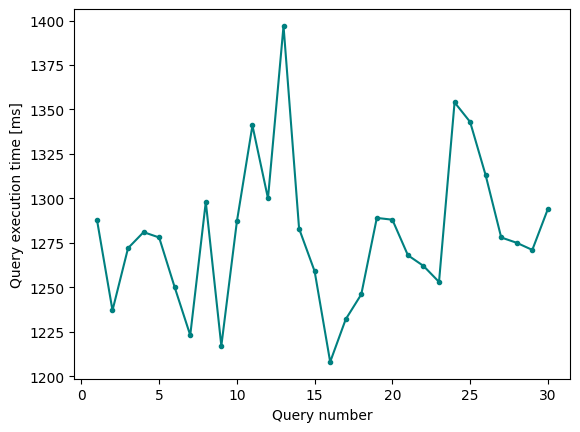

In [47]:
djikstra_query_times = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(dijkstra_benchmark)
    djikstra_query_times.append(parse_query_time(cursor))
    time.sleep(0.1)
    
print(f"queries times: {djikstra_query_times}")

plot_query_times(djikstra_query_times)

### Astar small distance, small database

In [48]:
cursor.execute(astar_benchmark)
query_time = parse_query_time(cursor)
print(f"query time: {query_time} ms")

query time: 1238 ms


Query: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]

queries times: [1264, 1222, 1268, 1176, 1267, 1188, 1268, 1235, 1396, 1206, 1212, 1299, 1239, 1205, 1194, 1162, 1194, 1153, 1187, 1214, 1196, 1242, 1185, 1207, 1179, 1197, 1178, 1187, 1197, 1211]


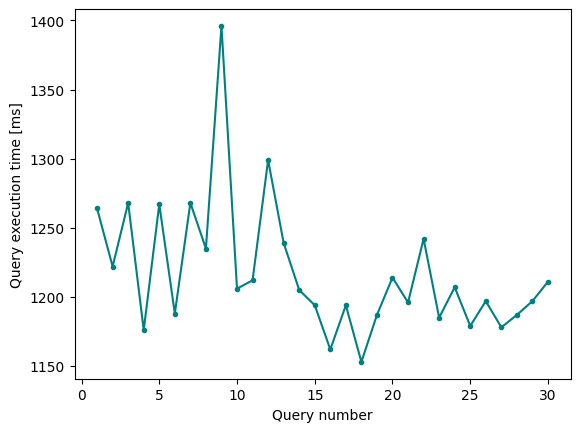

In [49]:
astar_query_times = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(astar_benchmark)
    astar_query_times.append(parse_query_time(cursor))
    time.sleep(0.1)
    
print(f"queries times: {astar_query_times}")

plot_query_times(astar_query_times)

In [50]:
conn.commit() 
conn.close() 

### Connect to big database

In [51]:
conn = psycopg2.connect(
    host="localhost",
    database="krakow_big",
    user="postgres",
    password="postgres")

In [52]:
conn.autocommit = True
cursor = conn.cursor() 

### Selection of nodes

In [53]:
nodes = pd.read_csv("./data/krakow_big/nodes_neo4j.csv")

In [54]:
distance_big = 0
osmid_1_big = 0
osmid_2_big = 0

while distance_big < 300:
    start_and_finish = nodes.sample(2)

    osmid_1_big = int(start_and_finish.iloc[0]["osmid"])
    osmid_2_big = int(start_and_finish.iloc[1]["osmid"])

    coords_1 = start_and_finish.iloc[0]["y"], start_and_finish.iloc[0]["x"]
    coords_2 = start_and_finish.iloc[1]["y"], start_and_finish.iloc[1]["x"]
    
    distance_big = geopy.distance.distance(coords_1, coords_2).km

print(f"osmid_1_big: {osmid_1_big}, osmid_2_big: {osmid_2_big}, distance: {distance_big} km")

osmid_1_big: 6479951071, osmid_2_big: 5904787656, distance: 309.0978542163276 km


### Update path queries

In [55]:
dijkstra_benchmark = f"""
    EXPLAIN ANALYZE 
    SELECT * FROM pgr_dijkstra(
    'SELECT id, source, target, length as cost, length as reverse_cost FROM edge_table',
    {osmid_1_big}, {osmid_2_big},
    directed => false);
"""
astar_benchmark = f"""
    EXPLAIN
    SELECT * FROM pgr_aStar(
    'SELECT id, source, target, length as cost, length as reverse_cost, x1, y1, x2, y2 FROM edge_table',
    {osmid_1_big}, {osmid_2_big},
    directed => false);
"""

### Check data size and number of records

In [56]:
cursor.execute(records_nb_query)
get_results(cursor)

['count']
(26649381,)


In [57]:
cursor.execute(size_query)
get_results(cursor)

['pg_size_pretty']
('124 MB',)


### Djikstra big distance, big database

In [58]:
cursor.execute(dijkstra_benchmark)
query_time = parse_query_time(cursor)
print(f"query time: {query_time} ms")

query time: 48508 ms


Query: 100%|██████████| 30/30 [21:03<00:00, 42.11s/it]

queries times: [45318, 42572, 44987, 42664, 45462, 44456, 44600, 41780, 41164, 40899, 41482, 40592, 40886, 44098, 42504, 42548, 43089, 40276, 41787, 42820, 42198, 41794, 39123, 39410, 39047, 40460, 41489, 39540, 39808, 43296]


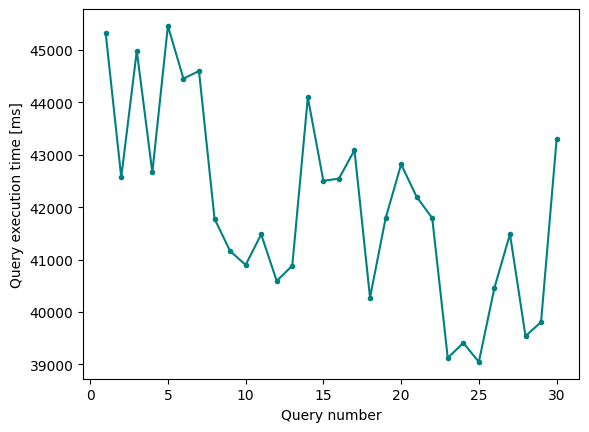

In [59]:
djikstra_query_times = []

for _ in tqdm(range(query_number), desc="Query"):
    cursor.execute(dijkstra_benchmark)
    djikstra_query_times.append(parse_query_time(cursor))
    time.sleep(0.1)
    
print(f"queries times: {djikstra_query_times}")

plot_query_times(djikstra_query_times)

### Astar big distance, big database

In [60]:
# memmory allocation error